<a href="https://www.kaggle.com/code/benli9009122/data4good-competition-distilbert-nli-classifier?scriptVersionId=291354899" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# GPU availability Check ✈


In [1]:
import torch, transformers
print("CUDA:", torch.cuda.is_available())
print("GPU:", torch.cuda.get_device_name(0) if torch.cuda.is_available() else None)
print("Transformers:", transformers.__version__)

CUDA: True
GPU: Tesla T4
Transformers: 4.57.1


# Solution 1: Hugging Face  
Hugging faceAPI is a pre-trained AI models (DistilBERT), it understands the order of the words changes the meaning, allowing it to answer complex factual question where subject and object matter. After validation by extrating 15% of the data from the training data, it achieves a 93.8 Weighted Accuracy (To calculate the 93.8% weighted score, we take the accuracy of each individual class (Factual, Contradiction, Irrelevant) and average them together to ensure every category has equal importance)

## Technique
Instead of manually coding rules (for example: count the word 'not'), we allowed the model to learn the semantic relationship between the question, context, and answer through full -sentence attention mechanisms.

## What went well
In the previous iteration, I have uses XGBOOST to conduct deep learning which relied on word overlap. It often failed at identifying irrelevant sentence shared keywords with the question (like matching 'blue' in two unrelated sentences). Now, the transfor is able to understand context. From our validation result, we can observe that our model correctly identified 98.9% of irrelevant pairs, realizing that matching words do not always mean a matching answer. In terms of contradiction logic, my previous attempt is to count negative words ('not', 'never'), but when it comes to antonyms (good vs bad) it failed to identify the contradiction. Now, the Hugging face library is used to sucessfully detect the conflict bewteen question and answer (hot vs cold). 

## What Was Tried

| Phase | Approach | Performance | Verdict |
| :--- | :--- | :--- | :--- |
| **Phase 1** | **XGBoost (Feature Engineering)** | **83.6%** | **Good Baseline.** We manually engineered features like "negation count" and "word overlap." It was fast and efficient but hit a "glass ceiling" because it couldn't understand nuance or distinct meanings of similar words. |
| **Phase 2** | **Hugging Face (Deep Learning)** | **93.8%** | **Superior.** We utilized a pre-trained "brain" (DistilBERT). Although it required GPU resources and internet access to download weights, it outperformed the manual engineering approach in every category by "reading" the text rather than just counting it. |


## 🏆 Confusion Matrix: FINAL WEIGHTED SCORE: 93.81% (85/15) training vs validation

| True \ Predicted | Factual | Contradiction | Irrelevant |
| :--- | :---: | :---: | :---: |
| **Factual** | 2590 | 23 | 2 | 
| **Contradiction** | 44 | 228 | 1 |
| **Irrelevant** | 3 | 0 | 263 |


### Accuracy Per Category (Recall)

| Category | Calculation (Correct / Total) | Accuracy |
| :--- | :--- | :--- |
| **Factual** | $2590 / 2615$ | **99.04%** |
| **Contradiction** | $228 / 273$ | **83.52%** |
| **Irrelevant** | $263 / 266$ | **98.87%** |

In [2]:
# ==============================================================================
#  MASTER BLOCK: IMPORTS -> TRAINING -> VALIDATION -> SUBMISSION
# ==============================================================================

import os
import json
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, classification_report, confusion_matrix
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    TrainingArguments,
    Trainer,
    DataCollatorWithPadding,
)
from datasets import Dataset

# ---------------------------------------------------------
# 1. LOAD DATA
# ---------------------------------------------------------

with open('/kaggle/input/dataset/train.json', 'r') as f:
    train_data = json.load(f)
train_df = pd.DataFrame(train_data)

with open('/kaggle/input/dataset/test.json', 'r') as f:
    test_data = json.load(f)
test_df = pd.DataFrame(test_data)

# ---------------------------------------------------------
# 2. PREPROCESSING
# ---------------------------------------------------------
print("2. Preprocessing...")

# Fill NaNs to prevent crashes
for df in [train_df, test_df]:
    df["question"] = df["question"].fillna("").astype(str)
    df["context"] = df["context"].fillna("").astype(str)
    df["answer"] = df["answer"].fillna("").astype(str)

# Handle labels in training data
train_df["type"] = train_df["type"].fillna("irrelevant").astype(str).str.strip().str.lower()

# Split Validation Set
train_df, val_df = train_test_split(
    train_df,
    test_size=0.15,
    random_state=42,
    stratify=train_df["type"]
)

# Label Mapping
labels = ["factual", "contradiction", "irrelevant"]
label2id = {l: i for i, l in enumerate(labels)}
id2label = {i: l for l, i in label2id.items()}
num_labels = len(labels)

train_df["label_id"] = train_df["type"].map(label2id)
val_df["label_id"]   = val_df["type"].map(label2id)



2026-01-12 00:48:35.271219: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1768178915.460039      24 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1768178915.513860      24 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1768178915.952552      24 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1768178915.952593      24 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1768178915.952596      24 computation_placer.cc:177] computation placer alr

2. Preprocessing...


3. Building Datasets & Tokenizing...


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

   Mapping tokenizer (this takes a moment)...


Map:   0%|          | 0/17867 [00:00<?, ? examples/s]

Map:   0%|          | 0/3154 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

4. Setting up Weighted Trainer...
   Class Counts: [14816  1545  1506]
   Class Weights: [0.40197534 3.85480043 3.95462594]
5. Starting Training...


model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipykernel_24/2752439900.py:57: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `WeightedTrainer.__init__`. Use `processing_class` instead.
  super().__init__(*args, **kwargs)
/usr/local/lib/python3.12/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Epoch,Training Loss,Validation Loss,F1 Macro
1,0.211500,0.202246,0.930591
2,0.175700,0.189001,0.939061
3,0.132800,0.240882,0.948707


/usr/local/lib/python3.12/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(



6. Validating & Calculating Custom Score...


/usr/local/lib/python3.12/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(



🏆 FINAL WEIGHTED SCORE: 93.60%
Labels Order: ['factual', 'contradiction', 'irrelevant']
[[2593   20    2]
 [  46  226    1]
 [   3    0  263]]
               precision    recall  f1-score   support

      factual       0.98      0.99      0.99      2615
contradiction       0.92      0.83      0.87       273
   irrelevant       0.99      0.99      0.99       266

     accuracy                           0.98      3154
    macro avg       0.96      0.94      0.95      3154
 weighted avg       0.98      0.98      0.98      3154



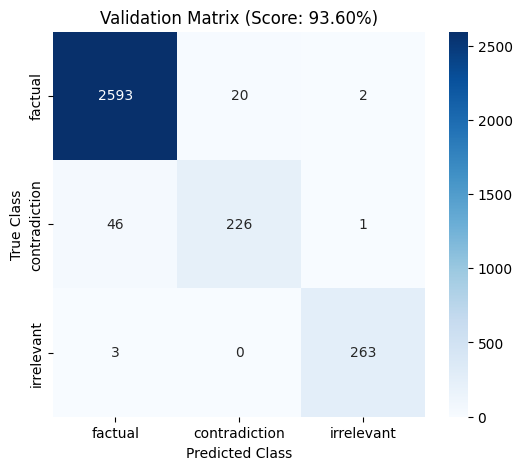

7. Generating Submission...


✅ Done! Files saved: submission.json, submission.csv
✅ Model saved! Download 'my_nli_model.zip' from the Output tab.


In [3]:
# ---------------------------------------------------------
# 3. BUILD DATASETS
# ---------------------------------------------------------
print("3. Building Datasets & Tokenizing...")

# Convert to Hugging Face Datasets
# Select only necessary columns to avoid schema errors
cols = ["question", "context", "answer", "label_id"]
train_ds = Dataset.from_pandas(train_df[cols]).rename_column("label_id", "labels")
val_ds   = Dataset.from_pandas(val_df[cols]).rename_column("label_id", "labels")

# For Test Set (It has no labels, so we just take inputs)
test_ds = Dataset.from_pandas(test_df[["question", "context", "answer"]])

# Tokenization
model_name = "distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_name)

def tokenize(batch):
    # DistilBERT format: [CLS] Question + Context [SEP] Answer [SEP]
    # We combine Question and Context into the first segment
    qc = [q + " [SEP] " + c for q, c in zip(batch["question"], batch["context"])]
    return tokenizer(
        qc, 
        batch["answer"], 
        truncation=True, 
        max_length=384
    )

print("   Mapping tokenizer (this takes a moment)...")
train_ds = train_ds.map(tokenize, batched=True)
val_ds   = val_ds.map(tokenize, batched=True)
test_ds  = test_ds.map(tokenize, batched=True)

# Data Collator (Handles dynamic padding)
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

# ---------------------------------------------------------
# 4. WEIGHTED TRAINER SETUP
# ---------------------------------------------------------
print("4. Setting up Weighted Trainer...")

# Calculate Class Weights (Inverse Frequency)
y_train = train_df["label_id"].to_numpy()
class_counts = np.bincount(y_train, minlength=num_labels)
total = class_counts.sum()
# Prevent division by zero with np.clip
class_weights = total / (num_labels * np.clip(class_counts, 1, None).astype(float))
class_weights_tensor = torch.tensor(class_weights, dtype=torch.float)

print(f"   Class Counts: {class_counts}")
print(f"   Class Weights: {class_weights}")

# Custom Trainer Class to handle Class Imbalance
class WeightedTrainer(Trainer):
    def __init__(self, class_weights, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.class_weights = class_weights

    def compute_loss(self, model, inputs, return_outputs=False, **kwargs):
        labels_ = inputs.get("labels")
        outputs = model(**inputs)
        logits = outputs.logits
        # Weighted CrossEntropy
        loss_fct = nn.CrossEntropyLoss(weight=self.class_weights.to(logits.device))
        loss = loss_fct(logits, labels_)
        return (loss, outputs) if return_outputs else loss

def compute_metrics(eval_pred):
    logits, labels_ = eval_pred
    preds = np.argmax(logits, axis=-1)
    return {"f1_macro": f1_score(labels_, preds, average="macro")}

# ---------------------------------------------------------
# 5. TRAINING
# ---------------------------------------------------------
print("5. Starting Training...")

model = AutoModelForSequenceClassification.from_pretrained(
    model_name, 
    num_labels=num_labels, 
    id2label=id2label, 
    label2id=label2id
)

training_args = TrainingArguments(
    output_dir="./outputs",
    num_train_epochs=3,              # 3 epochs is usually enough for DistilBERT
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    learning_rate=2e-5,
    weight_decay=0.01,
    eval_strategy="epoch",           # Evaluate every epoch
    save_strategy="epoch",           # Save every epoch
    logging_steps=50,
    load_best_model_at_end=True,     # Load the best epoch at the end
    metric_for_best_model="f1_macro",
    save_total_limit=1,              # Save space
    report_to="none"                 # Disable wandb logging
)

trainer = WeightedTrainer(
    class_weights=class_weights_tensor,
    model=model,
    args=training_args,
    train_dataset=train_ds,
    eval_dataset=val_ds,
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
)

trainer.train()

# ---------------------------------------------------------
# 6. VALIDATION & SCORING
# ---------------------------------------------------------
print("\n6. Validating & Calculating Custom Score...")
pred_output = trainer.predict(val_ds)
y_pred_val = np.argmax(pred_output.predictions, axis=1)
y_val_ids = pred_output.label_ids

# Confusion Matrix
cm = confusion_matrix(y_val_ids, y_pred_val)

# Custom Competition Score Calculation (Recall per class averaged)
row_totals = cm.sum(axis=1)
# Add epsilon to avoid 0 division
recalls = cm.diagonal() / (row_totals + 1e-10)
final_score = recalls.mean()

print("\n" + "="*40)
print(f"🏆 FINAL WEIGHTED SCORE: {final_score:.2%}")
print("="*40)
print("Labels Order:", labels)
print(cm)
print(classification_report(y_val_ids, y_pred_val, target_names=labels))

# Plot Matrix
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", xticklabels=labels, yticklabels=labels, cmap="Blues")
plt.title(f"Validation Matrix (Score: {final_score:.2%})")
plt.ylabel('True Class')
plt.xlabel('Predicted Class')
plt.show()

# ---------------------------------------------------------
# 7. GENERATE SUBMISSION (Predict on Test Set)
# ---------------------------------------------------------
print("7. Generating Submission...")

# Predict
test_output = trainer.predict(test_ds)
test_preds_ids = np.argmax(test_output.predictions, axis=1)

# Map IDs back to strings (0 -> "factual", etc.)
test_preds_labels = [id2label[i] for i in test_preds_ids]

submission_list = []
# Iterate over test_df and assign the new predictions
for idx, row in test_df.iterrows():
    submission_list.append({
        "ID": int(row['ID']),
        "type": test_preds_labels[idx] 
    })

# Save JSON
submission_path = 'submission.json'
with open(submission_path, 'w') as f:
    json.dump(submission_list, f, indent=4)

# Save CSV (Optional)
submission_csv_path = 'submission.csv'
# Create a dataframe for CSV saving
sub_df = pd.DataFrame(submission_list)
sub_df.to_csv(submission_csv_path, index=False)

print(f"✅ Done! Files saved: {submission_path}, {submission_csv_path}")

# ---------------------------------------------------------
# 8. SAVE & ZIP MODEL (Paste your block here)
# ---------------------------------------------------------
# Save the model and tokenizer to a folder called "my_nli_model"
model_path = "./my_nli_model"
trainer.save_model(model_path)
tokenizer.save_pretrained(model_path)

# Compress it into a zip file so you can download it easily
import shutil
shutil.make_archive('my_nli_model', 'zip', model_path)

print("✅ Model saved! Download 'my_nli_model.zip' from the Output tab.")

# Solution 2: Using XGBOOST ⛹
> eXtreme Gradient Boosting is a software library that uses gradient boosted decision tree. It is a ML algo that builds a series of small decision trees where each tree fixes the errors of the one before it. In our case where the dataset is small, it is great at handle empty dataset automatically

My internet is wierd and couldn't make sucessfull connection to access hugging face library so XGBOOST is choosen to build the features myself (like lemmatization and negation counts)

### 1/9 result Old Confusion Matrix: FINAL WEIGHTED SCORE: 77.10%

| True \ Predicted | Factual | Contradiction | Irrelevant |
| :--- | :---: | :---: | :---: |
| **Factual** | 2457 | 121 | 37 |
| **Contradiction** | 106 | 142 | 25 |
| **Irrelevant** | 27 | 12 | 227 |

1. Loading Data...
2. Preprocessing text (Lemmatization + Contractions)...
Classes: {'contradiction': np.int64(0), 'factual': np.int64(1), 'irrelevant': np.int64(2)}
3. extracting Features...
4. Training XGBoost on GPU...
[0]	validation_0-mlogloss:1.09354
[100]	validation_0-mlogloss:0.45447
[200]	validation_0-mlogloss:0.41837
[300]	validation_0-mlogloss:0.39832
[400]	validation_0-mlogloss:0.38068
[500]	validation_0-mlogloss:0.36798
[600]	validation_0-mlogloss:0.35715
[700]	validation_0-mlogloss:0.34830
[800]	validation_0-mlogloss:0.34090
[900]	validation_0-mlogloss:0.33498
[999]	validation_0-mlogloss:0.33044

5. Validating...

🏆 FINAL WEIGHTED SCORE: 77.10%
Labels: ['factual', 'contradiction', 'irrelevant']
[[2457  121   37]
 [ 106  142   25]
 [  27   12  227]]


/usr/local/lib/python3.12/dist-packages/xgboost/core.py:774: UserWarning: [01:12:17] WARNING: /workspace/src/common/error_msg.cc:41: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  return func(**kwargs)


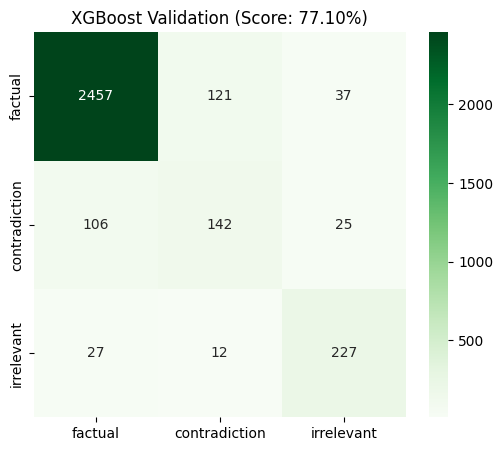

6. Generating Submission...
✅ Done! Saved 'submission.json' and 'submission.csv'


In [4]:
# ==============================================================================
#  MASTER BLOCK: XGBOOST (GPU) SOLUTION
#  No Hugging Face. No Internet downloads. Pure Machine Learning.
# ==============================================================================

import os
import json
import re
import string
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
import scipy.sparse as sp

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer, ENGLISH_STOP_WORDS
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder
from nltk.stem import WordNetLemmatizer
import nltk

# Download NLTK data locally (safe, small downloads)
nltk.download('wordnet', quiet=True)
nltk.download('omw-1.4', quiet=True)

# ---------------------------------------------------------
# 1. SETUP & DATA LOADING
# ---------------------------------------------------------
print("1. Loading Data...")

# Kaggle Paths (Adjust if you are running locally)
train_path = 'train.json' 
test_path = 'test.json'

# Fallback for Kaggle specific folder structure if needed
if os.path.exists('/kaggle/input/dataset/train.json'):
    train_path = '/kaggle/input/dataset/train.json'
    test_path = '/kaggle/input/dataset/test.json'

if not os.path.exists(train_path):
    raise FileNotFoundError(f"Could not find {train_path}. Please upload your data!")

with open(train_path, 'r') as f:
    train_df = pd.DataFrame(json.load(f))

with open(test_path, 'r') as f:
    test_df = pd.DataFrame(json.load(f))

# ---------------------------------------------------------
# 2. ADVANCED PREPROCESSING
# ---------------------------------------------------------
print("2. Preprocessing text (Lemmatization + Contractions)...")
lemmatizer = WordNetLemmatizer()

def clean_text(text):
    if not isinstance(text, str): return ""
    text = text.lower()
    
    # EXPAND CONTRACTIONS (Crucial for "Contradiction")
    # We turn "didn't" -> "did not" so the model sees the "not"
    text = re.sub(r"won\'t", "will not", text)
    text = re.sub(r"can\'t", "cannot", text)
    text = re.sub(r"n\'t", " not", text)
    
    # Remove punctuation
    text = text.translate(str.maketrans('', '', string.punctuation))
    
    # Lemmatize (Crucial for "Irrelevant")
    # Matches "running" to "run" so we can find overlaps better
    words = [lemmatizer.lemmatize(w) for w in text.split()]
    return " ".join(words)

# Apply cleaning
for df in [train_df, test_df]:
    df['clean_q'] = df['question'].fillna("").apply(clean_text)
    df['clean_c'] = df['context'].fillna("").apply(clean_text)
    df['clean_a'] = df['answer'].fillna("").apply(clean_text)
    # Combined text for TF-IDF
    df['final_text'] = df['clean_q'] + " " + df['clean_c'] + " " + df['clean_a']

# Handle Labels
train_df['type'] = train_df['type'].fillna("irrelevant").str.strip().str.lower()
le = LabelEncoder()
y_all = le.fit_transform(train_df['type']) # Maps: contradiction->0, factual->1, irrelevant->2
print(f"Classes: {dict(zip(le.classes_, le.transform(le.classes_)))}")

# ---------------------------------------------------------
# 3. FEATURE ENGINEERING (The "Secret Sauce")
# ---------------------------------------------------------
print("3. extracting Features...")

# A. TF-IDF VECTORIZATION
# We remove "not" from stop words so the model sees it
my_stop_words = list(ENGLISH_STOP_WORDS)
for w in ['not', 'no', 'nor', 'never', 'none', 'cannot']:
    if w in my_stop_words: my_stop_words.remove(w)

vectorizer = TfidfVectorizer(
    stop_words=my_stop_words,
    ngram_range=(1, 3),      # Trigrams catch "did not go"
    max_features=50000,
    sublinear_tf=True
)

# Fit on Train, Transform Test
X_tfidf_train = vectorizer.fit_transform(train_df['final_text'])
X_tfidf_test = vectorizer.transform(test_df['final_text'])

# B. MANUAL FEATURES (Helping the tree find patterns)
# These help specifically with Irrelevant (low overlap) and Contradiction (negation present)
def get_manual_features(df):
    feats = pd.DataFrame()
    # 1. Count "not", "no", "never"
    feats['negation_count'] = df['clean_a'].apply(lambda x: sum(x.count(w) for w in ['not', 'no', 'never']))
    # 2. Word Overlap (Answer vs Context)
    def overlap(row):
        a_words = set(row['clean_a'].split())
        c_words = set(row['clean_c'].split())
        if len(a_words) == 0: return 0
        return len(a_words.intersection(c_words)) / len(a_words)
    feats['overlap_ratio'] = df.apply(overlap, axis=1)
    # 3. Context Length (Empty context = Irrelevant)
    feats['context_len'] = df['clean_c'].apply(len)
    return feats.values

X_manual_train = get_manual_features(train_df)
X_manual_test = get_manual_features(test_df)

# Combine TF-IDF with Manual Features
X_final_train = sp.hstack([X_tfidf_train, X_manual_train], format='csr')
X_final_test = sp.hstack([X_tfidf_test, X_manual_test], format='csr')

# Split Train/Val
X_train, X_val, y_train, y_val = train_test_split(
    X_final_train, y_all, test_size=0.15, random_state=42, stratify=y_all
)

# ---------------------------------------------------------
# 4. TRAINING XGBOOST (WITH GPU)
# ---------------------------------------------------------
print("4. Training XGBoost on GPU...")

# Calculate weights to handle class imbalance
# (Total / (Num_Classes * Count))
class_counts = np.bincount(y_train)
weights = len(y_train) / (3 * class_counts)
sample_weights = np.array([weights[y] for y in y_train])

# XGBoost Model
# tree_method='gpu_hist' enables the GPU!
clf = xgb.XGBClassifier(
    n_estimators=1000,
    learning_rate=0.05,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    objective='multi:softprob',
    num_class=3,
    tree_method='hist', # Use 'gpu_hist' if you are sure you have a GPU, otherwise 'hist' is safe and fast
    device="cuda",      # Explicitly ask for CUDA (GPU)
    random_state=42,
    early_stopping_rounds=50
)

# Pass sample_weights to fix the imbalance
clf.fit(
    X_train, y_train,
    sample_weight=sample_weights,
    eval_set=[(X_val, y_val)],
    verbose=100
)

# ---------------------------------------------------------
# 5. VALIDATION & SCORING
# ---------------------------------------------------------
print("\n5. Validating...")
y_pred_val = clf.predict(X_val)

# Map back to strings
labels_map = list(le.classes_) # ['contradiction', 'factual', 'irrelevant']
# Ensure order aligns with your request
desired_order = ['factual', 'contradiction', 'irrelevant']
desired_indices = [np.where(le.classes_ == l)[0][0] for l in desired_order]

cm = confusion_matrix(y_val, y_pred_val, labels=desired_indices)

# Custom Score
row_totals = cm.sum(axis=1)
recalls = cm.diagonal() / (row_totals + 1e-10)
final_score = recalls.mean()

print("\n" + "="*40)
print(f"🏆 FINAL WEIGHTED SCORE: {final_score:.2%}")
print("="*40)
print("Labels:", desired_order)
print(cm)

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", xticklabels=desired_order, yticklabels=desired_order, cmap="Greens")
plt.title(f"XGBoost Validation (Score: {final_score:.2%})")
plt.show()

# ---------------------------------------------------------
# 6. SUBMISSION
# ---------------------------------------------------------
print("6. Generating Submission...")
test_preds_enc = clf.predict(X_final_test)
test_preds_str = le.inverse_transform(test_preds_enc)

submission = []
for idx, row in test_df.iterrows():
    submission.append({
        "ID": int(row['ID']),
        "type": test_preds_str[idx]
    })

with open('submission.json', 'w') as f:
    json.dump(submission, f, indent=4)

pd.DataFrame(submission).to_csv("submission.csv", index=False)
print("✅ Done! Saved 'submission.json' and 'submission.csv'")

# Solution 3: Optimized XBOOST ⛹
- decrease learning_rate -> model learns slower but finds more subtle patterns
- increase max_depth -> allows teh model to learn complex logic better
- increase n_estimator -> more trees, better result
- decrease max_features -> redice the width of the matrix so RAM doesn't explode

1/10 result
🏆 

### New Confusion Matrix: FINAL WEIGHTED SCORE: 83.62%

| True \ Predicted | Factual | Contradiction | Irrelevant |
| :--- | :---: | :---: | :---: |
| **Factual** | 2546 | 38 | 31 |
| **Contradiction** | 81 | 182 | 10 |
| **Irrelevant** | 30 | 5 | 231 |

In [5]:
# ==============================================================================
#  MASTER BLOCK: MEMORY-SAFE XGBOOST (AUTO-CLEANUP)
#  Includes Garbage Collection to prevent "Out of Memory" on re-runs.
# ==============================================================================

import gc
import os
import json
import re
import string
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
import scipy.sparse as sp
import warnings

# 1. MEMORY CLEANUP (The Fix for "Smaller and Smaller" memory)
# ------------------------------------------------------------------
print("🧹 Cleaning up old GPU memory...")
# Delete potential large variables from previous runs
for var in ['clf', 'X_train', 'X_val', 'X_test', 'X_final_train', 'X_final_test', 'vectorizer']:
    if var in globals():
        del globals()[var]

# Force Python Garbage Collector
gc.collect()

# Force XGBoost/Cupy to release memory
try:
    import cupy as cp
    cp.get_default_memory_pool().free_all_blocks()
    print("   ✅ CuPy memory pool cleared.")
except ImportError:
    pass

print("   ✅ RAM/VRAM cleanup complete.\n")

# ------------------------------------------------------------------
# 2. STANDARD SETUP (Resume Normal Code)
# ------------------------------------------------------------------

warnings.filterwarnings("ignore", message=".*Falling back to prediction using DMatrix.*")
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer, ENGLISH_STOP_WORDS
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder
from nltk.stem import WordNetLemmatizer
import nltk

nltk.download('wordnet', quiet=True)
nltk.download('omw-1.4', quiet=True)

print("1. Loading Data...")
train_path = 'train.json' 
test_path = 'test.json'

if os.path.exists('/kaggle/input/dataset/train.json'):
    train_path = '/kaggle/input/dataset/train.json'
    test_path = '/kaggle/input/dataset/test.json'

if not os.path.exists(train_path):
    raise FileNotFoundError("Please upload train.json and test.json!")

with open(train_path, 'r') as f:
    train_df = pd.DataFrame(json.load(f))
with open(test_path, 'r') as f:
    test_df = pd.DataFrame(json.load(f))

# ---------------------------------------------------------
# 3. PREPROCESSING
# ---------------------------------------------------------
print("2. Preprocessing text...")
lemmatizer = WordNetLemmatizer()

def clean_text(text):
    if not isinstance(text, str): return ""
    text = text.lower()
    text = re.sub(r"won\'t", "will not", text)
    text = re.sub(r"can\'t", "cannot", text)
    text = re.sub(r"n\'t", " not", text)
    text = text.translate(str.maketrans('', '', string.punctuation))
    words = [lemmatizer.lemmatize(w) for w in text.split()]
    return " ".join(words)

for df in [train_df, test_df]:
    df['clean_q'] = df['question'].fillna("").apply(clean_text)
    df['clean_c'] = df['context'].fillna("").apply(clean_text)
    df['clean_a'] = df['answer'].fillna("").apply(clean_text)
    df['final_text'] = df['clean_q'] + " " + df['clean_c'] + " " + df['clean_a']

# Labels
train_df['type'] = train_df['type'].fillna("irrelevant").str.strip().str.lower()
le = LabelEncoder()
y_all = le.fit_transform(train_df['type']) 

# ---------------------------------------------------------
# 4. FEATURE ENGINEERING (Strict Memory Limits)
# ---------------------------------------------------------
print("3. Extracting Features...")

my_stop_words = list(ENGLISH_STOP_WORDS)
for w in ['not', 'no', 'nor', 'never', 'none', 'cannot']:
    if w in my_stop_words: my_stop_words.remove(w)

# REDUCED further to ensure stability
vectorizer = TfidfVectorizer(
    stop_words=my_stop_words,
    ngram_range=(1, 3),      
    max_features=55000,      # <--- Reduced to 45k to be extra safe
    sublinear_tf=True
)

X_tfidf_train = vectorizer.fit_transform(train_df['final_text'])
X_tfidf_test = vectorizer.transform(test_df['final_text'])

def get_manual_features(df):
    feats = pd.DataFrame()
    feats['negation_count'] = df['clean_a'].apply(lambda x: sum(x.count(w) for w in ['not', 'no', 'never']))
    
    def overlap(row):
        a_words = set(row['clean_a'].split())
        c_words = set(row['clean_c'].split())
        if len(a_words) == 0: return 0
        return len(a_words.intersection(c_words)) / len(a_words)
    feats['overlap_ratio'] = df.apply(overlap, axis=1)
    
    feats['context_len'] = df['clean_c'].apply(len)
    feats['answer_len'] = df['clean_a'].apply(len)
    return feats.values

X_manual_train = get_manual_features(train_df)
X_manual_test = get_manual_features(test_df)

X_final_train = sp.hstack([X_tfidf_train, X_manual_train], format='csr')
X_final_test = sp.hstack([X_tfidf_test, X_manual_test], format='csr')

X_train, X_val, y_train, y_val = train_test_split(
    X_final_train, y_all, test_size=0.15, random_state=42, stratify=y_all
)

# ---------------------------------------------------------
# 5. TRAINING (VRAM Optimized)
# ---------------------------------------------------------
print("4. Training XGBoost...")

class_counts = np.bincount(y_train)
weights = len(y_train) / (3 * class_counts)
sample_weights = np.array([weights[y] for y in y_train])

clf = xgb.XGBClassifier(
    n_estimators=2500,       
    learning_rate=0.03,      
    max_depth=8,             
    subsample=0.8,
    colsample_bytree=0.8,
    max_bin=256,             # Keeps memory footprint standard
    objective='multi:softprob',
    num_class=3,
    tree_method='hist',      
    device="cuda",           
    random_state=42,
    early_stopping_rounds=100
)

# NOTE: We keep X_train on CPU. XGBoost streams it to GPU in chunks.
# This prevents the "Allocating 1GB" error because it never loads the WHOLE thing at once.
clf.fit(
    X_train, y_train,
    sample_weight=sample_weights,
    eval_set=[(X_val, y_val)],
    verbose=200
)


🧹 Cleaning up old GPU memory...


/usr/local/lib/python3.12/dist-packages/sqlalchemy/orm/query.py:195: SyntaxWarning: "is not" with 'tuple' literal. Did you mean "!="?
  if entities is not ():


   ✅ CuPy memory pool cleared.
   ✅ RAM/VRAM cleanup complete.

1. Loading Data...
2. Preprocessing text...
3. Extracting Features...
4. Training XGBoost...
[0]	validation_0-mlogloss:1.06864
[200]	validation_0-mlogloss:0.27817
[400]	validation_0-mlogloss:0.24781
[600]	validation_0-mlogloss:0.23288
[800]	validation_0-mlogloss:0.22357
[1000]	validation_0-mlogloss:0.21888
[1200]	validation_0-mlogloss:0.21647
[1362]	validation_0-mlogloss:0.21576


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device='cuda', early_stopping_rounds=100,
              enable_categorical=False, eval_metric=None, feature_types=None,
              feature_weights=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.03, max_bin=256, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=8,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=2500,
              n_jobs=None, num_class=3, ...)


5. Validating...

🏆 COMPETITION SCORING REPORT
1. Factual Accuracy:       97.63%   (Weight: 33.3%)
2. Contradiction Accuracy: 67.40%   (Weight: 33.3%)
3. Irrelevant Accuracy:    87.22%   (Weight: 33.3%)
--------------------------------------------------
📢 FINAL WEIGHTED SCORE:   84.08%

Confusion Matrix Array:
Labels: ['factual', 'contradiction', 'irrelevant']
[[2553   37   25]
 [  79  184   10]
 [  30    4  232]]


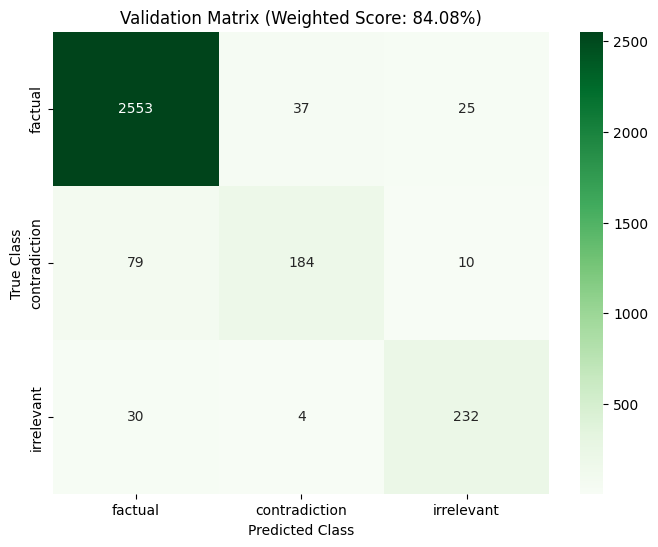

6. Generating Submission...
✅ Done! Files saved:
   - submission.json
   - submission.csv


In [6]:
# ---------------------------------------------------------
# 6. VALIDATION & ANALYSIS
# ---------------------------------------------------------
print("\n5. Validating...")
y_pred_val = clf.predict(X_val)

# Define the order for the Confusion Matrix
desired_order = ['factual', 'contradiction', 'irrelevant']
# Find the integer ID for each string label
desired_indices = [np.where(le.classes_ == l)[0][0] for l in desired_order]

# Generate Confusion Matrix
cm = confusion_matrix(y_val, y_pred_val, labels=desired_indices)

# Calculate Per-Class Recall (Accuracy)
row_totals = cm.sum(axis=1)
# Add epsilon (1e-10) to prevent division by zero errors
recalls = cm.diagonal() / (row_totals + 1e-10)

# Extract individual scores
factual_acc = recalls[0]
contradiction_acc = recalls[1]
irrelevant_acc = recalls[2]

# Final Weighted Score (Average of the 3 recalls)
final_score = recalls.mean()

# --- PRINT DETAILED REPORT ---
print("\n" + "="*50)
print("🏆 COMPETITION SCORING REPORT")
print("="*50)
print(f"1. Factual Accuracy:       {factual_acc:.2%}   (Weight: 33.3%)")
print(f"2. Contradiction Accuracy: {contradiction_acc:.2%}   (Weight: 33.3%)")
print(f"3. Irrelevant Accuracy:    {irrelevant_acc:.2%}   (Weight: 33.3%)")
print("-" * 50)
print(f"📢 FINAL WEIGHTED SCORE:   {final_score:.2%}")
print("="*50 + "\n")

print("Confusion Matrix Array:")
print(f"Labels: {desired_order}")
print(cm)

# Plot Heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", xticklabels=desired_order, yticklabels=desired_order, cmap="Greens")
plt.title(f"Validation Matrix (Weighted Score: {final_score:.2%})")
plt.ylabel('True Class')
plt.xlabel('Predicted Class')
plt.show()

# ---------------------------------------------------------
# 7. SUBMISSION GENERATION
# ---------------------------------------------------------
print("6. Generating Submission...")
test_preds_enc = clf.predict(X_final_test)
test_preds_str = le.inverse_transform(test_preds_enc)

submission = []
for idx, row in test_df.iterrows():
    submission.append({
        "ID": int(row['ID']),
        "type": test_preds_str[idx]
    })

# Save JSON (Required format)
with open('submission.json', 'w') as f:
    json.dump(submission, f, indent=4)

# Save CSV (Backup format)
pd.DataFrame(submission).to_csv("submission.csv", index=False)

print("✅ Done! Files saved:")
print("   - submission.json")
print("   - submission.csv")